# Homework 3

In this homework, we optimized the matrix-vector computation using CUDA parallelism on GPUS. To do so, we defined the following multipliers to test different multiplications methods and timed each for analysis below:

1. `AtomicSingleWarpMultiplier` - A multiplier that uses a single thread warp to compute a given output value, with the work distributed evenly. To aggregate data at the end, this multiplier uses the `atomicAdd` operation.
2. `ShuffleSingleWarpMultiplier` - Also uses a single warp to compute a row worth of data, but this time uses the warp shuffling mechanism that we discussed in class.
3. `MultipleWarpMultiplier` - A multiplier that instead uses multiple warps to compute a single row value. 
4. `WideMatrixMultiplier` - A multiplier optimized for the sort of "wide" matrices that were mentioned in the handout (few rows, but many columns). This utilizes a transpose operation to try and optimize the speed of these sorts of matrices.

More in-depth comparison of each of these multipliers will be presented later in this report, as well as the required roof-line analysis.

All of our code can be found in the `homework_3/src/benchmark.cu` file of the linked repository.

In [50]:
# Initial Data Preparation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

benchmark = pd.read_csv('../data/benchmark.csv')
benchmark_wide = pd.read_csv('../data/benchmark_wide.csv')

## Roof-Line Analysis

To perform the roof-line analysis required, we choose to focus on the results for the `n = 10000, m = 10000` operations.

We note that the arithmetic intensity computation is nearly identical to the one that we did in the previous assignment, so the total number of floating point operations is still 2, and the number of memory operations is also the same, meaning our resulting arithmetic intensity is 

$$
    \text{Arithmetic Intensity} = \frac{2 \ \text{FLOPS}}{36 \ \text{Accesses}} = \frac{1}{18} \ \frac{\text{FLOPS}}{\text{byte}}
$$

However, this time, we are running our code on the GPU, and not the CPU. Although we tested our kernels on Oscar, we ended up doing our final benchmarking on one of our laptops with a GPU, where running the `nvidia-smi` tells us that we are running on an Nvidia RTX A2000 GPU, which from the resources [here](https://www.techpowerup.com/gpu-specs/rtx-a2000.c3820) has a peak floating point FLOP rate of 7.987 TFLOPS, and a maximum memory bandwidth of 288.0 GB/s. 

The ridge point of our roofline plot is therefore given by:

$$
    I^* = \frac{\text{Maximum FLOP Rate}}{\text{Maximum Memory Bandwidth}} = \frac{7.987 \ \text{TFLOPS}}{288.0 \ \text{GB/s}} = 27.7 \ \frac{\text{FLOPs}}{\text{byte}}
$$

The predicted FLOP rate is given by:
$$
    \text{Predicted FLOP Rate} = \frac{1 \ \text{FLOPS}}{18 \ \text{byte}} \cdot \frac{288.0 \cdot 10^9 \ \text{bytes}}{1 \ \text{second}} = 16.0 \ \text{GFLOPs}
$$

Therefore, we are in bandwidth-limited region of the roof-line plot. This is within the margin of error of the experimental results we determined.

,i,n,m,repetitions,multiplier,time_us,stddev_us,flops
55,56,10000,10000,10,MultipleWarpMultiplier,7190.700195,4.0,278.137031


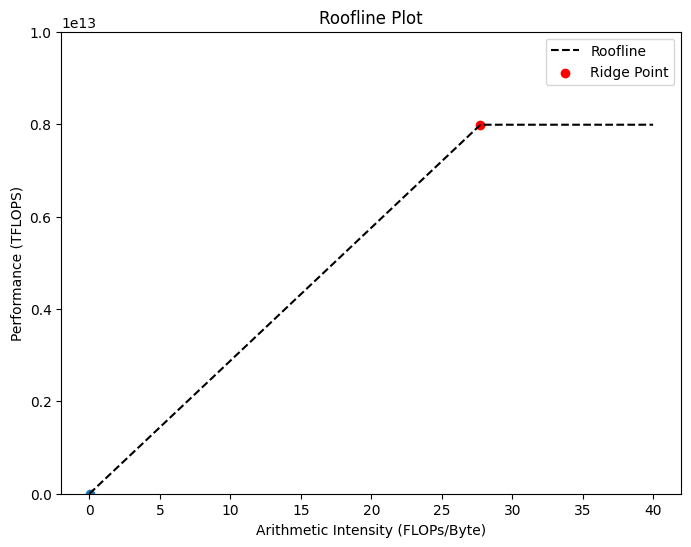

In [57]:
# Compute the roof-line plot for the analysis above.
benchmark['flops'] = 2 * benchmark['n']**3 / benchmark['time_us'] * 1e6 / 1e12
subset = benchmark[benchmark['multiplier'] == 'MultipleWarpMultiplier']
subset = subset[subset['n'] == 10000]
subset = subset[subset['m'] == 10000]

# Plot the roof-line plot
max_flop_rate = 7.987e12 
max_mem_bandwidth = 288.0e9
ridge_point = max_flop_rate / max_mem_bandwidth

arithmetic_intensity = np.arange(0, 40, 0.01);
roofline = np.minimum(arithmetic_intensity * max_mem_bandwidth, max_flop_rate)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(arithmetic_intensity, roofline, 'k--', label='Roofline')
ax.scatter(ridge_point, ridge_point * max_mem_bandwidth, marker='o', color='r', label='Ridge Point')

ax.scatter(1/14 * np.ones(len(subset)), subset["flops"])

ax.set_ylim(0, 10e12)
ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
ax.set_ylabel('Performance (TFLOPS)')
ax.set_title('Roofline Plot')
ax.legend()

subset

## Atomic vs Shuffle Performance

When we were looking into additional CUDA resources online, we found several guides that suggested the use of CUDA `atomicAdd` operations to perform the sort of aggregation that we used the `shuffle` operation for in class, and so we wanted to see how much of a performance drawback or advantage that this provided.

So, to test this, we made the only difference between the `AtomicSingleWarpMultiplier` and the `ShuffleSingleWarpMultiplier` the aggregation method, so any performance difference can be attributed to this.

As you can see in the graph below, the `Atomic` version suffers worse performance for smaller matrices, but this seems to go away as the size of the matrix gets larger. This makes sense in hindsight, as the atomic operation synchronization takes up a larger percentage of the compute time when the size of the matrix is small (each one has a relatively small amount of work to do, so they all try to synchronize at the same time), but this effect decreases when each thread has a larger amount of work to do, since they implicitly don't all end up finishing at the same time.

We feel that this is an interesting case to consider, and will definitely be something we consider when writing CUDA kernels for our final project.

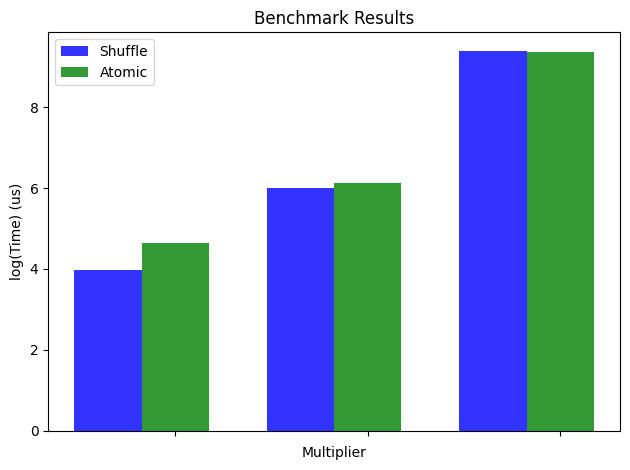

In [52]:
benchmark_shuffle = benchmark[benchmark['multiplier'] == "ShuffleSingleWarpMultiplier"]
benchmark_shuffle = benchmark_shuffle[benchmark_shuffle['n'] == 10000]
benchmark_shuffle['log_time'] = np.log(benchmark_shuffle['time_us'])
benchmark_atomic = benchmark[benchmark['multiplier'] == "AtomicSingleWarpMultiplier"]
benchmark_atomic = benchmark_atomic[benchmark_atomic['n'] == 10000]
benchmark_atomic['log_time'] = np.log(benchmark_atomic['time_us'])

columns = ["m", "time_us"]

# print(benchmark_shuffle[columns])
# print(benchmark_atomic[columns])

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, benchmark_shuffle['log_time'], bar_width,
                    alpha=opacity,
                    color='b',
                    label='Shuffle')

rects2 = plt.bar(index + bar_width, benchmark_atomic['log_time'], bar_width,
                    alpha=opacity,
                    color='g',
                    label='Atomic')

plt.xlabel('Multiplier')
plt.ylabel('log(Time) (us)')
plt.title('Benchmark Results')
plt.xticks(index + bar_width, (''))
plt.legend()

plt.tight_layout()
plt.show()

## Wide Matrix Optimization

The purpose of the `WideMatrixMultiplier` is to be efficient when computing with matrices of size `10 x 10^n` for `n >> 1`. We ran these experiments separately, and we can see the results of comparing this for matrices of size `10 x 10000` with the other multipliers.

We see quite clearly that this certainly performed better than the single warp multipliers, but actually did worse than the multi-warp one.

Again, this actually makes sense. Since the single warp multipliers only use 32 threads to compute the row of data, the computational task is not distributed efficiently. Still, it is interesting to see that transposing the matrix and then using the single warp on each piece of data is still significantly faster in this case.

Still, the multi-warp distribution seems to be the fastest because it most efficiently distributes the workload.

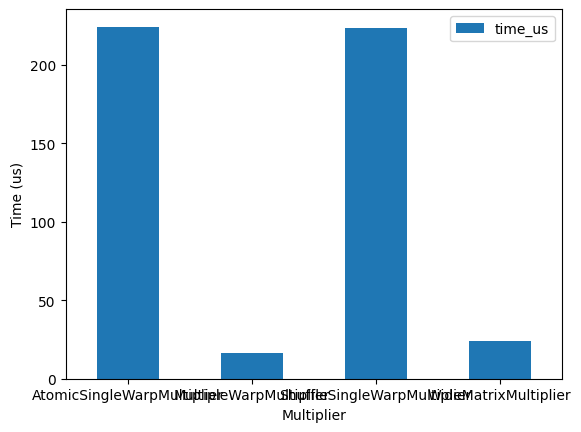

In [53]:
df = benchmark[benchmark['n'] == 10]
df = df[df['m'] == 10000]

df_2 = benchmark_wide[benchmark_wide['m'] == 10000]

c = pd.concat([df, df_2])
# print(c[['multiplier', 'time_us']])

# Plot the results in a single bar graph
c.plot.bar(x='multiplier', y='time_us', rot=0)

plt.xlabel('Multiplier')
plt.ylabel('Time (us)')
plt.show()



## Single vs Multiple Warps

As seen by the multipliers, we wanted to determine whether using single or multiple warps to process a single row of input data would yield a speedup.

It is clear from looking at the data that the single warp case generally performed much worse than the multiple-warp kernel that we wrote, which can be seen in the graphs below. Again, this makes sense because when using multiple warps, we are able to more efficiently distribute the workload across the GPU.

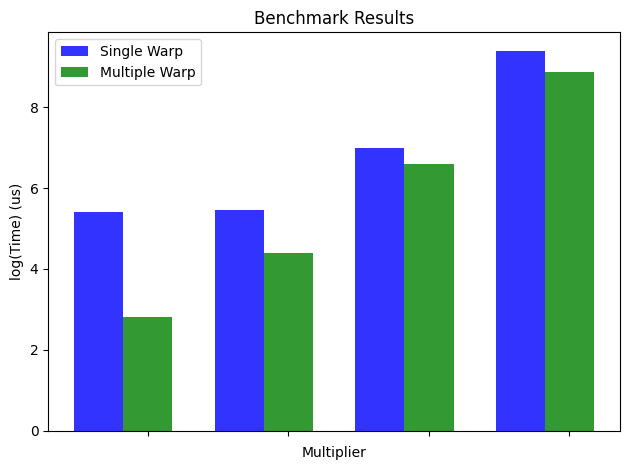

In [54]:
# Select the Single Shuffle multiplier and the multiple warp one for m = 10000 and varying n
df = benchmark[benchmark['m'] == 10000]
df = df[df['multiplier'] == "ShuffleSingleWarpMultiplier"]
df['log_time'] = np.log(df['time_us'])
df_2 = benchmark[benchmark['m'] == 10000]
df_2 = df_2[df_2['multiplier'] == "MultipleWarpMultiplier"]
df_2['log_time'] = np.log(df_2['time_us'])

c = pd.concat([df, df_2])
# print(c[['n', 'multiplier', 'time_us']])

fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df['log_time'], bar_width,
                    alpha=opacity,
                    color='b',
                    label='Single Warp')

rects2 = plt.bar(index + bar_width, df_2['log_time'], bar_width,
                    alpha=opacity,
                    color='g',
                    label='Multiple Warp')

plt.xlabel('Multiplier')
plt.xticks(index + bar_width, ('100', '1000', '10000', '100000'))
plt.ylabel('log(Time) (us)')
plt.title('Benchmark Results')
plt.xticks(index + bar_width, (''))
plt.legend()

plt.tight_layout()
plt.show()
